# Objectives

# Section 1: Loading and Preprocess the data

## 1.1: Preprocess each CSV file 

In [2]:
#Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

#Importing the necessary libraries
import pandas as pd
from prettypandas import PrettyPandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Preprocess Trade Indicators - FAOSTAT_data_en_2-22-2024.csv file

In [3]:
# Load the dataset
df_trade = pd.read_csv('./Food trade indicators - FAOSTAT_data_en_2-22-2024.csv')

# Select the columns and rename them
df_trade = df_trade[['Area', 'Item', 'Year', 'Element', 'Value']]

# Drop rows with any empty values
df_trade = df_trade.dropna()

# Pivot the table for 'Import Value' and 'Export Value'
df_import = df_trade[df_trade['Element'] == 'Import Value'].pivot_table(
    index=['Area', 'Item', 'Year'],
    values='Value',
    aggfunc='first'
).rename(columns={'Value': 'Import_Value'}).reset_index()

df_export = df_trade[df_trade['Element'] == 'Export Value'].pivot_table(
    index=['Area', 'Item', 'Year'],
    values='Value',
    aggfunc='first'
).rename(columns={'Value': 'Export_Value'}).reset_index()

# Merge the pivoted DataFrames on 'Area', 'Item', and 'Year'
df_trade_values = pd.merge(df_import, df_export, on=['Area', 'Item', 'Year'], how='inner')

# Create a new column for 'Year' 3 years ahead
df_trade_values['Year_3_Ahead'] = df_trade_values['Year'] + 3

# Merge with itself to get export value 3 years ahead
df_trade_values = pd.merge(df_trade_values, df_trade_values[['Area', 'Item', 'Year', 'Export_Value']],
                           left_on=['Area', 'Item', 'Year_3_Ahead'], right_on=['Area', 'Item', 'Year'],
                           suffixes=('', '_3_Years_Ahead'), how='left')

# Sort by 'Area', 'Item', 'Year' to ensure chronological order for lag and rolling calculations
df_trade_values.sort_values(by=['Area', 'Item', 'Year'], inplace=True)

# Function to create lag and rolling window features within each group
def create_features(group):
    # Create lag features for 'Export_Value'
    group['Export_Value_Lag1'] = group['Export_Value'].shift(1)
    group['Export_Value_Lag2'] = group['Export_Value'].shift(2)
    group['Export_Value_Lag3'] = group['Export_Value'].shift(3)

    # Create a 3-year rolling mean for 'Export_Value'
    group['Export_Value_Rolling_Mean3'] = group['Export_Value'].rolling(window=3).mean()

    return group

# Apply the function to each group
df_trade_values = df_trade_values.groupby(['Area', 'Item']).apply(create_features)

# Drop rows with any NaN values created by the lag and rolling operations
df_trade_values.dropna(inplace=True)

# Drop unnecessary columns
df_trade_values.drop(['Year_3_Ahead', 'Year_3_Years_Ahead'], axis=1, inplace=True)

# One-hot encode the 'Item' columns but keep the original column
item_columns = df_trade_values['Item']
df_trade_values = pd.get_dummies(df_trade_values, columns=['Item'])
df_trade_values['Item'] = item_columns

### Preprocess Pesticides use - FAOSTAT_data_en_2-27-2024.csv file

In [4]:
# Load the dataset
df_pesticides = pd.read_csv('./Pesticides use - FAOSTAT_data_en_2-27-2024.csv')

# Select the columns
df_pesticides = df_pesticides[['Area', 'Item', 'Year', 'Element', 'Value']]

# Drop rows with any empty values
df_pesticides = df_pesticides.dropna()

# Pivot the table
df_pesticides_pivot = df_pesticides.pivot_table(
    index=['Area', 'Year'],
    columns=['Item', 'Element'],
    values='Value',
    aggfunc='first'
).reset_index()

# Join with _
df_pesticides_pivot.columns = ['_'.join(col).strip() for col in df_pesticides_pivot.columns.values]
df_pesticides_pivot = df_pesticides_pivot.rename(columns={'Area_': 'Area', 'Year_': 'Year'})

# Rename the columns
df_pesticides_pivot = df_pesticides_pivot.rename(columns=lambda x: f'Pesticide_{x}' if x not in ['Area', 'Year'] else x)

PrettyPandas(df_pesticides_pivot.head())

,Area,Year,Pesticide_Fungicides and Bactericides_Agricultural Use,Pesticide_Fungicides – Seed treatments_Agricultural Use,Pesticide_Herbicides_Agricultural Use,Pesticide_Insecticides_Agricultural Use,Pesticide_Insecticides – Seed Treatments_Agricultural Use,Pesticide_Pesticides (total)_Agricultural Use,Pesticide_Pesticides (total)_Use per area of cropland,Pesticide_Pesticides (total)_Use per value of agricultural production,Pesticide_Rodenticides_Agricultural Use
0,Albania,2000,105.730000,0.050000,7.990000,169.600000,9.010000,307.980000,0.440000,0.230000,7.540000
1,Albania,2001,108.080000,0.060000,7.990000,174.520000,10.810000,319.380000,0.460000,0.230000,8.250000
2,Albania,2002,110.430000,0.070000,7.980000,179.440000,12.610000,330.780000,0.470000,0.240000,8.960000
3,Albania,2003,112.770000,0.080000,7.980000,184.360000,14.410000,342.170000,0.490000,0.240000,9.670000
4,Albania,2004,115.120000,0.090000,7.980000,189.280000,16.210000,353.570000,0.510000,0.230000,10.370000


### Preprocess Land use - FAOSTAT_data_en_2-22-2024.csv file

In [5]:
# Load the dataset
df_land_use = pd.read_csv('./Land use - FAOSTAT_data_en_2-22-2024.csv', low_memory=False)

# Select the columns
df_land_use = df_land_use[['Area', 'Year', 'Item', 'Value']]

# Drop rows with any empty values
df_land_use = df_land_use.dropna()

# Drop rows with 'Item' = 'Country are' and 'Land area'
df_land_use = df_land_use.loc[~df_land_use['Item'].isin(['Country area', 'Land area', 'Agricultural land'])]

# Drop rows with any empty values
df_land_use = df_land_use.dropna()

# Pivot the table to have one row per 'Area' and 'Year' and each 'Item' as a column
df_land_use_pivot = df_land_use.pivot_table(
    index=['Area', 'Year'],
    columns='Item',
    values='Value'
).reset_index()

# Rename the columns
df_land_use_pivot.columns = ['Area', 'Year'] + [f'LandUse_{col}' for col in df_land_use_pivot.columns[2:]]

PrettyPandas(df_land_use_pivot.head())

,Area,Year,LandUse_Agriculture,LandUse_Agriculture area actually irrigated,LandUse_Arable land,LandUse_Cropland,LandUse_Cropland area actually irrigated,LandUse_Farm buildings and Farmyards,LandUse_Forestry area actually irrigated,LandUse_Land area actually irrigated,LandUse_Land area equipped for irrigation,LandUse_Perm. meadows & pastures - Cultivated,LandUse_Perm. meadows & pastures - Nat. growing,LandUse_Perm. meadows & pastures area actually irrig.,LandUse_Permanent crops,LandUse_Permanent meadows and pastures,LandUse_Temporary crops,LandUse_Temporary fallow,LandUse_Temporary meadows and pastures
0,Afghanistan,1980,38049.000000,nan,7910.000000,8049.000000,nan,nan,nan,nan,2505.000000,nan,nan,nan,139.000000,30000.000000,nan,nan,nan
1,Afghanistan,1981,38053.000000,nan,7910.000000,8053.000000,nan,nan,nan,nan,2520.000000,nan,nan,nan,143.000000,30000.000000,nan,nan,nan
2,Afghanistan,1982,38054.000000,nan,7910.000000,8054.000000,nan,nan,nan,nan,2535.000000,nan,nan,nan,144.000000,30000.000000,nan,nan,nan
3,Afghanistan,1983,38054.000000,nan,7910.000000,8054.000000,nan,nan,nan,nan,2550.000000,nan,nan,nan,144.000000,30000.000000,nan,nan,nan
4,Afghanistan,1984,38054.000000,nan,7910.000000,8054.000000,nan,nan,nan,nan,2581.000000,nan,nan,nan,144.000000,30000.000000,nan,nan,nan


### Preprocess Land temperature change - FAOSTAT_data_en_2-27-2024.csv

In [6]:
# Load the dataset
df_temperature = pd.read_csv('./Land temperature change - FAOSTAT_data_en_2-27-2024.csv')

# Select the columns
df_temperature = df_temperature[['Area', 'Months', 'Year', 'Element', 'Value']]

# Drop rows with any empty values
df_temperature = df_temperature.dropna()

# Filter for 'Temperature change' during the 'Meteorological year'
df_temperature_annual = df_temperature[
    (df_temperature['Element'] == 'Temperature change') &
    (df_temperature['Months'] == 'Meteorological year')
]

# Select relevant columns
df_temperature_annual = df_temperature_annual[['Area', 'Year', 'Value']]

# Rename the columns
df_temperature_annual.rename(columns={'Value': 'TempChange_Annual'}, inplace=True)

PrettyPandas(df_temperature_annual.head())


,Area,Year,TempChange_Annual
184,Afghanistan,2000,0.993000
185,Afghanistan,2001,1.311000
186,Afghanistan,2002,1.365000
187,Afghanistan,2003,0.587000
188,Afghanistan,2004,1.373000


### Preprocess Foreign direct investment - FAOSTAT_data_en_2-27-2024.csv

In [7]:
# Load the dataset
df_fdi = pd.read_csv('./Foreign direct investment - FAOSTAT_data_en_2-27-2024.csv')

# Select the columns
df_fdi_relevant = df_fdi[['Area', 'Year', 'Item', 'Value']]

# Drop rows with any empty values
df_fdi_relevant = df_fdi_relevant.dropna()

# Use FDI inflows to agriculture only
df_fdi_agri = df_fdi_relevant[df_fdi_relevant['Item'].str.contains('FDI inflows to Agriculture, Forestry and Fishing')]

# Pivot the table
df_fdi_pivot = df_fdi_agri.pivot_table(
    index=['Area', 'Year'],
    columns='Item',
    values='Value'
).reset_index()

# Rename the columns
df_fdi_pivot.rename(columns=lambda x: f'{x.replace(", ", "_").replace(" ", "_")}' if x not in ['Area', 'Year'] else x, inplace=True)

PrettyPandas(df_fdi_pivot.head())


Item,Area,Year,FDI_inflows_to_Agriculture_Forestry_and_Fishing
0,Albania,2004,0.642888
1,Albania,2005,0.494601
2,Albania,2006,2.508966
3,Albania,2007,2.737334
4,Albania,2008,-79.100597


### Preprocess Food security indicators  - FAOSTAT_data_en_2-22-2024.csv

In [8]:
# Load the dataset
df_food_security = pd.read_csv('./Food security indicators  - FAOSTAT_data_en_2-22-2024.csv')

# Select the columns
df_food_security = df_food_security[['Area', 'Year', 'Item', 'Value']]

# Filter for relevant 'Item' categories based on the focus of the analysis
irrelevant_items = [
    'Prevalence of anemia among women of reproductive age (15-49 years)',
    'Prevalence of low birthweight (percent)',
    'Per capita food production variability (constant 2014-2016 thousand int$ per capita)',
    'Percent of arable land equipped for irrigation (percent) (3-year average)'
]

# Drop irrelevant items
df_food_security_relevant = df_food_security[~df_food_security['Item'].isin(irrelevant_items)].copy()

# Drop rows with any empty values
df_food_security_relevant = df_food_security_relevant.dropna()
    
# Convert 'Year' to a string to handle both single years and ranges (e.g., '2000-2002')
df_food_security_relevant['Year'] = df_food_security_relevant['Year'].astype(str)

# Split into yearly and 3-year average DataFrames
df_yearly = df_food_security_relevant[~df_food_security_relevant['Year'].str.contains('-')]
df_3year_avg = df_food_security_relevant[df_food_security_relevant['Year'].str.contains('-')]

# Expand 3-year averages into annual values
expanded_rows = []
for _, row in df_3year_avg.iterrows():
    start_year, end_year = map(int, row['Year'].split('-'))
    for year in range(start_year, end_year + 1):
        new_row = row.copy()
        new_row['Year'] = str(year)
        expanded_rows.append(new_row)

df_expanded = pd.DataFrame(expanded_rows)

# Merge expanded 3-year data with yearly data, giving precedence to yearly data
df_combined = pd.concat([df_yearly, df_expanded]).drop_duplicates(subset=['Area', 'Year', 'Item'], keep='first')

# Pivot the table
df_fsi_combined_pivot = df_combined.pivot_table(
    index=['Area', 'Year'],
    columns='Item',
    values='Value',
    aggfunc='first'
).reset_index()

# Rename the columns
df_fsi_combined_pivot.columns = ['Area', 'Year'] + [f'FSI_{c.replace(", ", "_").replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_")}' 
                                                    for c in df_fsi_combined_pivot.columns[2:]]

PrettyPandas(df_fsi_combined_pivot.head())


,Area,Year,FSI_Average_dietary_energy_supply_adequacy_percent_3_year_average,FSI_Average_protein_supply_g/cap/day_3_year_average,FSI_Cereal_import_dependency_ratio_percent_3_year_average,FSI_Per_capita_food_supply_variability_kcal/cap/day,FSI_Political_stability_and_absence_of_violence/terrorism_index,FSI_Value_of_food_imports_in_total_merchandise_exports_percent_3_year_average
0,Afghanistan,2000,88.000000,51.400000,34.100000,58.000000,-2.440000,240.000000
1,Afghanistan,2001,88.000000,51.400000,34.100000,47.000000,nan,240.000000
2,Afghanistan,2002,88.000000,51.400000,34.100000,71.000000,-2.040000,240.000000
3,Afghanistan,2003,89.000000,52.100000,29.300000,72.000000,-2.200000,281.000000
4,Afghanistan,2004,92.000000,54.000000,21.100000,50.000000,-2.300000,199.000000


### Preprocess Food balances indicators - FAOSTAT_data_en_2-22-2024.csv

In [9]:
# Load the dataset
df_food_balances = pd.read_csv('./Food balances indicators - FAOSTAT_data_en_2-22-2024.csv')

# Select columns
df_food_balances_relevant = df_food_balances[['Area', 'Year', 'Element', 'Item', 'Value']]

# Drop rows with any empty values
df_food_balances_relevant = df_food_balances_relevant.dropna()

# Drop rows with Item = Meat, Eggs, Milk - Excluding Butter, Fish, Seafood
df_food_balances_relevant = df_food_balances_relevant.loc[~df_food_balances_relevant['Item'].isin(['Meat', 'Eggs', 'Milk - Excluding Butter', 'Fish, Seafood'])]

# only keep elements 'export quantity'
df_food_balances_relevant = df_food_balances_relevant.loc[df_food_balances_relevant['Element'] == 'Export Quantity']

# Create a new column 'Element_Item' combining 'Element' and 'Item'
df_food_balances_relevant['Element_Item'] = df_food_balances_relevant['Element'] + '_' + df_food_balances_relevant['Item']

# Pivot the table
df_food_balances_pivot = df_food_balances_relevant.pivot_table(
    index=['Area', 'Year'],
    columns='Element_Item',
    values='Value',
    aggfunc='first'
).reset_index()

# Rename the columns
df_food_balances_pivot.rename(columns=lambda x: f'FoodBalance_{x.replace(" ", "_").replace(",", "_").replace("-", "_").replace("/", "_")}' 
                            if x not in ['Area', 'Year'] else x, inplace=True)

PrettyPandas(df_food_balances_pivot.head())

Element_Item,Area,Year,FoodBalance_Export_Quantity_Alcoholic_Beverages,FoodBalance_Export_Quantity_Cereals___Excluding_Beer,FoodBalance_Export_Quantity_Fruits___Excluding_Wine,FoodBalance_Export_Quantity_Oilcrops,FoodBalance_Export_Quantity_Pulses,FoodBalance_Export_Quantity_Spices,FoodBalance_Export_Quantity_Starchy_Roots,FoodBalance_Export_Quantity_Stimulants,FoodBalance_Export_Quantity_Sugar_&_Sweeteners,FoodBalance_Export_Quantity_Sugar_Crops,FoodBalance_Export_Quantity_Treenuts,FoodBalance_Export_Quantity_Vegetable_Oils,FoodBalance_Export_Quantity_Vegetables
0,Afghanistan,2010,nan,0.000000,158.000000,15.000000,1.000000,6.000000,26.000000,nan,0.000000,nan,5.000000,nan,149.000000
1,Afghanistan,2011,nan,0.000000,173.000000,11.000000,0.000000,4.000000,9.000000,nan,0.000000,nan,7.000000,nan,73.000000
2,Afghanistan,2012,nan,0.000000,142.000000,12.000000,0.000000,3.000000,4.000000,nan,0.000000,nan,9.000000,nan,28.000000
3,Afghanistan,2013,nan,0.000000,175.000000,11.000000,0.000000,5.000000,41.000000,nan,0.000000,nan,12.000000,nan,37.000000
4,Afghanistan,2014,0.000000,2.000000,252.000000,18.000000,29.000000,21.000000,7.000000,0.000000,1.000000,nan,12.000000,1.000000,69.000000


### Preprocess Fertilizers use - FAOSTAT_data_en_2-27-2024.csv

In [10]:
# Load the dataset
df_fertilizers = pd.read_csv('./Fertilizers use - FAOSTAT_data_en_2-27-2024.csv')

# Select the columns
df_fertilizers_relevant = df_fertilizers[['Area', 'Year', 'Item', 'Value']]

# Drop rows with any empty values
df_fertilizers_relevant = df_fertilizers_relevant.dropna()

# Pivot the table
df_fertilizers_pivot = df_fertilizers_relevant.pivot_table(
    index=['Area', 'Year'],
    columns='Item',
    values='Value',
    aggfunc='first'
).reset_index()

# Rename the columns
df_fertilizers_pivot.rename(columns=lambda x: f'FertilizerUse_{x.replace(" ", "_").replace(",", "_").replace("-", "_").replace("(", "").replace(")", "")}' 
                            if x not in ['Area', 'Year'] else x, inplace=True)

PrettyPandas(df_fertilizers_pivot.head())

Item,Area,Year,FertilizerUse_Ammonia__anhydrous,FertilizerUse_Ammonium_nitrate_AN,FertilizerUse_Ammonium_sulphate,FertilizerUse_Calcium_ammonium_nitrate_CAN_and_other_mixtures_with_calcium_carbonate,FertilizerUse_Diammonium_phosphate_DAP,FertilizerUse_Fertilizers_n.e.c.,FertilizerUse_Monoammonium_phosphate_MAP,FertilizerUse_NPK_fertilizers,FertilizerUse_Other_NK_compounds,FertilizerUse_Other_NP_compounds,FertilizerUse_Other_nitrogenous_fertilizers__n.e.c.,FertilizerUse_Other_phosphatic_fertilizers__n.e.c.,FertilizerUse_Other_potassic_fertilizers__n.e.c.,FertilizerUse_PK_compounds,FertilizerUse_Phosphate_rock,FertilizerUse_Potassium_chloride_muriate_of_potash_MOP,FertilizerUse_Potassium_nitrate,FertilizerUse_Potassium_sulphate_sulphate_of_potash_SOP,FertilizerUse_Sodium_nitrate,FertilizerUse_Superphosphates_above_35%,FertilizerUse_Superphosphates__other,FertilizerUse_Urea,FertilizerUse_Urea_and_ammonium_nitrate_solutions_UAN
0,Afghanistan,2002,nan,nan,nan,nan,nan,nan,nan,17900.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,Afghanistan,2003,nan,nan,nan,nan,nan,nan,nan,33200.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,Afghanistan,2004,nan,nan,nan,nan,nan,nan,nan,47700.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,42300.000000,nan
3,Afghanistan,2005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20577.000000,nan
4,Afghanistan,2006,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,68253.000000,nan


### Preprocess Exchange rate - FAOSTAT_data_en_2-22-2024.csv

In [11]:
# Load the dataset
df_exchange_rates = pd.read_csv('./Exchange rate - FAOSTAT_data_en_2-22-2024.csv')

# Select the columns
df_exchange_rates = df_exchange_rates[['Area', 'Year', 'Value']]

# Drop rows with any empty values
df_exchange_rates = df_exchange_rates.dropna()

# Group by 'Area' and 'Year' and calculate the mean 'Value'
df_yearly_exchange_rates = df_exchange_rates.groupby(['Area', 'Year'])['Value'].mean().reset_index()

# Rename the column
df_yearly_exchange_rates.rename(columns={'Value': 'Average_Exchange_Rate'}, inplace=True)

PrettyPandas(df_yearly_exchange_rates.head())

,Area,Year,Average_Exchange_Rate
0,Afghanistan,1980,44.129167
1,Afghanistan,1981,49.479902
2,Afghanistan,1982,50.599608
3,Afghanistan,1983,50.599608
4,Afghanistan,1984,50.599606


### Preprocess Emissions - FAOSTAT_data_en_2-27-2024.csv

In [12]:
# Load the dataset
df_emissions = pd.read_csv('./Emissions - FAOSTAT_data_en_2-27-2024.csv')

# Select the columns
df_emissions = df_emissions[['Area', 'Year', 'Element', 'Item', 'Value']]

# Drop rows with any empty values
df_emissions = df_emissions.dropna()

# Pivot the table
df_emissions_pivot = df_emissions.pivot_table(
    index=['Area', 'Year'],
    columns=['Element', 'Item'],
    values='Value',
    aggfunc='first'
).reset_index()

# Join with '_'
df_emissions_pivot.columns = ['_'.join(col).strip() for col in df_emissions_pivot.columns.values]

# Rename columns
df_emissions_pivot.columns = ['Area', 'Year'] + [f'Emission_{c.replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_")}' 
                                                for c in df_emissions_pivot.columns[2:]]

PrettyPandas(df_emissions_pivot.head())

,Area,Year,Emission_Crops_total_Emissions_CH4_All_Crops,Emission_Crops_total_Emissions_N2O_All_Crops,Emission_Emissions_CO2_Cropland_organic_soils,Emission_Emissions_CO2_Grassland_organic_soils,Emission_Emissions_N2O_Cropland_organic_soils,Emission_Emissions_N2O_Grassland_organic_soils
0,Afghanistan,2000,20.847100,0.705600,0.000000,0.000000,0.000000,0.000000
1,Afghanistan,2001,19.260500,0.705400,0.000000,0.000000,0.000000,0.000000
2,Afghanistan,2002,21.255300,1.065600,0.000000,0.000000,0.000000,0.000000
3,Afghanistan,2003,23.701700,1.311700,0.000000,0.000000,0.000000,0.000000
4,Afghanistan,2004,30.308900,1.085600,0.000000,0.000000,0.000000,0.000000


### Preprocess Crops production indicators - FAOSTAT_data_en_2-22-2024.csv

In [13]:
# Load the dataset
df_crops = pd.read_csv('./Crops production indicators - FAOSTAT_data_en_2-22-2024.csv')

# Select the columns
df_crops_filtered = df_crops[['Area', 'Year', 'Element', 'Item', 'Value']]

# Drop rows with any empty values
df_crops_filtered = df_crops_filtered.dropna()

# Pivot the table
df_crops_pivoted = df_crops_filtered.pivot_table(index=['Area', 'Year'], columns='Item', values='Value').reset_index()

# Rename the columns
df_crops_pivoted = df_crops_pivoted.rename(columns=lambda x: 'CropYield_' + x.replace(', ', '_').replace(' ', '_').replace('(', '').replace(')', '') 
                                        if x not in ['Area', 'Year'] else x)

PrettyPandas(df_crops_pivoted.head())


Item,Area,Year,CropYield_Cereals_primary,CropYield_Citrus_Fruit_Total,CropYield_Fibre_Crops_Fibre_Equivalent,CropYield_Fruit_Primary,CropYield_Oilcrops_Cake_Equivalent,CropYield_Oilcrops_Oil_Equivalent,CropYield_Pulses_Total,CropYield_Roots_and_Tubers_Total,CropYield_Sugar_Crops_Primary,CropYield_Treenuts_Total,CropYield_Vegetables_Primary
0,Afghanistan,2000,8063.000000,71245.000000,3990.000000,76730.000000,3833.000000,2231.000000,10203.000000,167857.000000,177273.000000,16378.000000,124154.000000
1,Afghanistan,2001,10067.000000,71417.000000,3990.000000,80268.000000,3829.000000,2217.000000,10262.000000,167857.000000,177273.000000,16190.000000,124344.000000
2,Afghanistan,2002,16698.000000,71477.000000,3990.000000,80174.000000,3818.000000,2202.000000,10317.000000,164286.000000,177273.000000,18370.000000,123884.000000
3,Afghanistan,2003,14580.000000,73423.000000,3850.000000,82792.000000,3844.000000,2532.000000,10712.000000,166667.000000,174286.000000,16328.000000,124287.000000
4,Afghanistan,2004,13348.000000,78025.000000,3843.000000,79157.000000,3951.000000,2716.000000,10769.000000,176471.000000,162500.000000,12909.000000,132255.000000


### Preprocess Consumer prices indicators - FAOSTAT_data_en_2-22-2024.csv

In [14]:
# Load the dataset
df_consumer_prices = pd.read_csv('./Consumer prices indicators - FAOSTAT_data_en_2-22-2024.csv')

# Select the columns
df_consumer_prices = df_consumer_prices[['Area', 'Year', 'Item', 'Value']]

# Drop rows with any empty values
df_consumer_prices = df_consumer_prices.dropna()

# Pivot the table
df_consumer_prices_pivot = df_consumer_prices.pivot_table(
    index=['Area', 'Year'],
    columns='Item',
    values='Value',
    aggfunc='mean'  # Use mean to aggregate monthly data into a single annual value
).reset_index()

# Rename the columns
df_consumer_prices_pivot.rename(columns={
    'Consumer Prices, Food Indices (2015 = 100)': 'ConsumerPrice_Food_Indices',
    'Food price inflation': 'ConsumerPrice_Food_Price_Inflation'
}, inplace=True)

PrettyPandas(df_consumer_prices_pivot.head())

Item,Area,Year,ConsumerPrice_Food_Indices,ConsumerPrice_Food_Price_Inflation
0,Afghanistan,2000,26.629848,nan
1,Afghanistan,2001,29.893548,12.780692
2,Afghanistan,2002,35.344892,18.254516
3,Afghanistan,2003,40.203113,14.102244
4,Afghanistan,2004,45.840561,14.072172


### Preprocess Employment - FAOSTAT_data_en_2-27-2024.csv

In [15]:
# Load the dataset
df_employment = pd.read_csv('./Employment - FAOSTAT_data_en_2-27-2024.csv')

# Select the columns
df_employment = df_employment[['Area', 'Year', 'Indicator', 'Value']]

# Drop rows with any empty values
df_employment = df_employment.dropna()

# Pivot the table
df_employment_pivot = df_employment.pivot_table(
    index=['Area', 'Year'],
    columns='Indicator',
    values='Value',
    aggfunc='first'
).reset_index()

# Rename columns
df_employment_pivot.rename(columns={
    'Mean weekly hours actually worked per employed person in agriculture, forestry and fishing': 'Employment_Agriculture_Work_Hours_Per_Week',
    'Employment in agriculture, forestry and fishing - ILO modelled estimates': 'Employment_Agriculture_Estimates'
}, inplace=True)

PrettyPandas(df_employment_pivot.head())

Indicator,Area,Year,Employment_Agriculture_Estimates,Employment_Agriculture_Work_Hours_Per_Week
0,Afghanistan,2000,2765.950000,nan
1,Afghanistan,2001,2805.540000,nan
2,Afghanistan,2002,2897.510000,nan
3,Afghanistan,2003,3093.270000,nan
4,Afghanistan,2004,3212.460000,nan


## 1.2: Perform Merging of DataFrames

In [16]:
# Ensure 'Area' and 'Year' are not part of the index
df_trade_values = df_trade_values.reset_index(drop=True)

# Ensure 'Area' is string type and 'Year' is string type in all DataFrames
df_trade_values['Area'] = df_trade_values['Area'].astype(str)
df_trade_values['Year'] = df_trade_values['Year'].astype(str)

df_pesticides_pivot['Area'] = df_pesticides_pivot['Area'].astype(str)
df_pesticides_pivot['Year'] = df_pesticides_pivot['Year'].astype(str)

df_land_use_pivot['Area'] = df_land_use_pivot['Area'].astype(str)
df_land_use_pivot['Year'] = df_land_use_pivot['Year'].astype(str)

df_temperature_annual['Area'] = df_temperature_annual['Area'].astype(str)
df_temperature_annual['Year'] = df_temperature_annual['Year'].astype(str)

df_fdi_pivot['Area'] = df_fdi_pivot['Area'].astype(str)
df_fdi_pivot['Year'] = df_fdi_pivot['Year'].astype(str)

df_fsi_combined_pivot['Area'] = df_fsi_combined_pivot['Area'].astype(str)
df_fsi_combined_pivot['Year'] = df_fsi_combined_pivot['Year'].astype(str)

df_food_balances_pivot['Area'] = df_food_balances_pivot['Area'].astype(str)
df_food_balances_pivot['Year'] = df_food_balances_pivot['Year'].astype(str)

df_fertilizers_pivot['Area'] = df_fertilizers_pivot['Area'].astype(str)
df_fertilizers_pivot['Year'] = df_fertilizers_pivot['Year'].astype(str)

df_yearly_exchange_rates['Area'] = df_yearly_exchange_rates['Area'].astype(str)
df_yearly_exchange_rates['Year'] = df_yearly_exchange_rates['Year'].astype(str)

df_emissions_pivot['Area'] = df_emissions_pivot['Area'].astype(str)
df_emissions_pivot['Year'] = df_emissions_pivot['Year'].astype(str)

df_crops_pivoted['Area'] = df_crops_pivoted['Area'].astype(str)
df_crops_pivoted['Year'] = df_crops_pivoted['Year'].astype(str)

df_consumer_prices_pivot['Area'] = df_consumer_prices_pivot['Area'].astype(str)
df_consumer_prices_pivot['Year'] = df_consumer_prices_pivot['Year'].astype(str)

df_employment_pivot['Area'] = df_employment_pivot['Area'].astype(str)
df_employment_pivot['Year'] = df_employment_pivot['Year'].astype(str)


# Merge the DataFrames
df_merged = df_trade_values
df_merged = pd.merge(df_merged, df_land_use_pivot, on=['Area', 'Year'], how='left')
df_merged = pd.merge(df_merged, df_temperature_annual, on=['Area', 'Year'], how='left') 
df_merged = pd.merge(df_merged, df_fdi_pivot, on=['Area', 'Year'], how='left')
df_merged = pd.merge(df_merged, df_fsi_combined_pivot, on=['Area', 'Year'], how='left')
df_merged = pd.merge(df_merged, df_food_balances_pivot, on=['Area', 'Year'], how='left')
df_merged = pd.merge(df_merged, df_fertilizers_pivot, on=['Area', 'Year'], how='left')
df_merged = pd.merge(df_merged, df_yearly_exchange_rates, on=['Area', 'Year'], how='left')
df_merged = pd.merge(df_merged, df_emissions_pivot, on=['Area', 'Year'], how='left')
df_merged = pd.merge(df_merged, df_crops_pivoted, on=['Area', 'Year'], how='left')
df_merged = pd.merge(df_merged, df_consumer_prices_pivot, on=['Area', 'Year'], how='left')
df_merged = pd.merge(df_merged, df_employment_pivot, on=['Area', 'Year'], how='left')

## 1.3: Recoding labels into classes


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Calculate percentiles for each item type
def calculate_percentiles(df):
    low = np.percentile(df['Export_Value_3_Years_Ahead'], 33) 
    medium = np.percentile(df['Export_Value_3_Years_Ahead'], 66)
    return {
        'low': low,
        'medium': medium,
    }

# Apply calculate_percentiles to each group
percentiles = df_merged.groupby('Item').apply(lambda df: calculate_percentiles(df))

# Convert the results to a dictionary
if not isinstance(percentiles, dict):
    percentiles = percentiles.to_dict()

# Categorize based on the percentiles
def categorize_value(row):
    thresholds = percentiles[row['Item']]
    value = row['Export_Value_3_Years_Ahead']
    if value <= thresholds['low']:
        return 0 # Low
    elif value <= thresholds['medium'] and value > thresholds['low']:
        return 1 # Medium
    else:
        return 2 # High

df_merged['Export_Value_3_Years_Ahead_Category'] = df_merged.apply(categorize_value, axis=1)

# Count the unique number of labels
num_labels = df_merged['Export_Value_3_Years_Ahead_Category'].nunique()
print(f"Number of unique labels: {num_labels}")

Number of unique labels: 3


In [18]:
# Dropping the columns
df_merged = df_merged.drop(columns=['Area'])
df_merged = df_merged.drop(columns=['Year'])
df_merged = df_merged.drop(columns=['Export_Value_3_Years_Ahead'])

# Dropping duplicate rows
df_merged = df_merged.drop_duplicates()

# Section 2: Selecting training, validation, and test sets

In [19]:
from sklearn.model_selection import train_test_split

def split_data(df, test_size=0.2, validation_size=0.25): 
    df_train, df_temp = train_test_split(df, test_size=test_size, random_state=42)
    df_validation, df_test = train_test_split(df_temp, test_size=validation_size, random_state=42)
    return df_train, df_validation, df_test

grouped = df_merged.groupby('Item')
train_list = []
validation_list = []
test_list = []

for name, group in grouped:
    train, validation, test = split_data(group)
    train_list.append(train)
    validation_list.append(validation)
    test_list.append(test)

train_df = pd.concat(train_list)
val_df = pd.concat(validation_list)
test_df = pd.concat(test_list)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Section 3: Imputing missing data, select features

In [20]:
from sklearn.impute import KNNImputer

# Drop Item column
train_df = train_df.drop(columns=['Item'])
val_df = val_df.drop(columns=['Item'])
test_df = test_df.drop(columns=['Item'])

# Drop columns with missing values percentage greater than 50%
missing_values = train_df.isnull().mean()
columns_to_drop = missing_values[missing_values > 0.5].index
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)
val_df.drop(columns=columns_to_drop, inplace=True)

In [21]:
# Select features using RFE with a Random Forest model
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

#columns start with 'Item' 
item_columns = [col for col in train_df.columns if 'Item_' in col]

# Define the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the RFE
rfe = RFE(model, n_features_to_select=20)

# Fit the RFE
X_train = train_df.drop(columns=['Export_Value_3_Years_Ahead_Category'] + item_columns)
y_train = train_df['Export_Value_3_Years_Ahead_Category']
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_].tolist()
print(f"Selected features: {selected_features}")

#apply the selected features to the datasets
train_df = train_df[selected_features + ['Export_Value_3_Years_Ahead_Category'] + item_columns]
val_df = val_df[selected_features + ['Export_Value_3_Years_Ahead_Category'] + item_columns]
test_df = test_df[selected_features + ['Export_Value_3_Years_Ahead_Category'] + item_columns]

Selected features: ['Import_Value', 'Export_Value', 'Export_Value_Lag1', 'Export_Value_Lag2', 'Export_Value_Lag3', 'Export_Value_Rolling_Mean3', 'LandUse_Agriculture', 'LandUse_Arable land', 'LandUse_Cropland', 'LandUse_Land area equipped for irrigation', 'LandUse_Permanent crops', 'LandUse_Permanent meadows and pastures', 'FSI_Average_protein_supply_g/cap/day_3_year_average', 'FSI_Value_of_food_imports_in_total_merchandise_exports_percent_3_year_average', 'Average_Exchange_Rate', 'Emission_Crops_total_Emissions_N2O_All_Crops', 'CropYield_Cereals_primary', 'CropYield_Oilcrops_Cake_Equivalent', 'CropYield_Oilcrops_Oil_Equivalent', 'CropYield_Vegetables_Primary']


In [22]:
# Drop the target column
X_train = train_df.drop(columns=['Export_Value_3_Years_Ahead_Category'])
y_train = train_df['Export_Value_3_Years_Ahead_Category']

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Fit the imputer on the training data and transform it
train_df_imputed = imputer.fit_transform(train_df)
train_df = pd.DataFrame(train_df_imputed, columns=train_df.columns)

# Transform the test data with the same imputer
test_df_imputed = imputer.transform(test_df)
test_df = pd.DataFrame(test_df_imputed, columns=test_df.columns)

# Transform the validation data
val_df_imputed = imputer.transform(val_df)
val_df = pd.DataFrame(val_df_imputed, columns=val_df.columns)

# Section 4: Scaling/normalization

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Select features to scale
features_to_scale = [feature for feature in train_df.columns if feature != 'Export_Value_3_Years_Ahead_Category']

# Fit the scaler on the training data
scaler.fit(train_df[features_to_scale])

# Apply the scaling
scaled_train_data = scaler.transform(train_df[features_to_scale])
scaled_val_data = scaler.transform(val_df[features_to_scale])
scaled_test_data = scaler.transform(test_df[features_to_scale])

# Add the target variable 'Export_Value_3_Years_Ahead' back
scaled_train_df = pd.DataFrame(scaled_train_data, columns=features_to_scale)
scaled_val_df = pd.DataFrame(scaled_val_data, columns=features_to_scale)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=features_to_scale)

scaled_train_df['Export_Value_3_Years_Ahead_Category'] = train_df['Export_Value_3_Years_Ahead_Category'].values
scaled_val_df['Export_Value_3_Years_Ahead_Category'] = val_df['Export_Value_3_Years_Ahead_Category'].values
scaled_test_df['Export_Value_3_Years_Ahead_Category'] = test_df['Export_Value_3_Years_Ahead_Category'].values

# Check the scaled training dataset
PrettyPandas(scaled_train_df.head())

,Import_Value,Export_Value,Export_Value_Lag1,Export_Value_Lag2,Export_Value_Lag3,Export_Value_Rolling_Mean3,LandUse_Agriculture,LandUse_Arable land,LandUse_Cropland,LandUse_Land area equipped for irrigation,LandUse_Permanent crops,LandUse_Permanent meadows and pastures,FSI_Average_protein_supply_g/cap/day_3_year_average,FSI_Value_of_food_imports_in_total_merchandise_exports_percent_3_year_average,Average_Exchange_Rate,Emission_Crops_total_Emissions_N2O_All_Crops,CropYield_Cereals_primary,CropYield_Oilcrops_Cake_Equivalent,CropYield_Oilcrops_Oil_Equivalent,CropYield_Vegetables_Primary,Item_Alcoholic Beverages,Item_Cereals and Preparations,Item_Dairy Products and Eggs,Item_Fats and Oils (excluding Butter),Item_Fruit and Vegetables,Item_Meat and Meat Preparations,Item_Non-alcoholic Beverages,Item_Non-edible Fats and Oils,Item_Non-food,Item_Other food,Item_Sugar and Honey,Item_Tobacco,Export_Value_3_Years_Ahead_Category
0,-0.268980,-0.254013,-0.250791,-0.248111,-0.244865,-0.252297,-0.379929,-0.354770,-0.370088,-0.248827,-0.371601,-0.344213,0.500403,1.766183,-0.015344,-0.277553,7.790035,-0.744751,-0.313260,-0.464276,-0.299672,-0.308004,-0.296081,-0.302497,-0.316326,-0.299022,-0.295096,-0.260874,3.148817,-0.319544,-0.304064,-0.296409,0.000000
1,-0.262246,-0.103120,-0.248912,-0.247546,-0.164031,-0.198819,-0.333500,-0.252903,-0.266535,-0.247983,-0.292340,-0.327388,-1.234831,-0.256871,-0.015340,-0.254816,-0.739931,-0.938936,-0.401230,-0.990686,-0.299672,-0.308004,-0.296081,-0.302497,-0.316326,-0.299022,-0.295096,-0.260874,3.148817,-0.319544,-0.304064,-0.296409,1.000000
2,-0.270896,-0.254207,-0.250961,-0.249323,-0.245923,-0.252809,-0.371971,-0.336618,-0.352881,-0.248314,-0.370032,-0.341094,-0.826845,1.316615,-0.015344,-0.274004,-1.004593,-0.791379,-0.442247,-0.872194,3.336978,-0.308004,-0.296081,-0.302497,-0.316326,-0.299022,-0.295096,-0.260874,-0.317580,-0.319544,-0.304064,-0.296409,0.000000
3,-0.254280,-0.181176,-0.175844,-0.162202,-0.184523,-0.174209,-0.301782,-0.180668,-0.198914,-0.160086,-0.294694,-0.314541,-0.730787,-0.182824,-0.015342,-0.245431,-0.202442,0.004446,-0.042334,-0.347238,-0.299672,-0.308004,-0.296081,-0.302497,3.161299,-0.299022,-0.295096,-0.260874,-0.317580,-0.319544,-0.304064,-0.296409,1.000000
4,-0.119183,0.083080,0.134733,0.096710,0.062194,0.105205,-0.202547,-0.065540,0.001861,0.185577,0.638936,-0.269678,1.657226,-0.415542,-0.015344,-0.018574,0.595868,1.822152,-0.081012,0.987726,-0.299672,-0.308004,-0.296081,-0.302497,-0.316326,-0.299022,3.388726,-0.260874,-0.317580,-0.319544,-0.304064,-0.296409,2.000000


# Section 5: Building and evaluating a multilayer perceptron (MLP)

In [24]:
from tensorflow.keras import layers, models, regularizers, callbacks
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight

np.random.seed(42)
tf.random.set_seed(42)

n_classes = 3

model = models.Sequential([
    layers.Dense(512, activation='relu',
                kernel_regularizer=regularizers.l2(0.002)), 
    layers.Dense(256, activation='relu',
                kernel_regularizer=regularizers.l2(0.002)), 
    layers.Dense(128, activation='relu',
                kernel_regularizer=regularizers.l2(0.002)), 
    layers.Dense(64, activation='relu',
                kernel_regularizer=regularizers.l2(0.002)), 
    layers.Dense(32, activation='relu',
                kernel_regularizer=regularizers.l2(0.002)), 
    layers.Dense(16, activation='relu',
                kernel_regularizer=regularizers.l2(0.002)), 
    layers.Dense(n_classes, activation='softmax')  
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add Early Stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Prepare feature and target datasets for training, validation, and testing
X_train = scaled_train_df.drop(columns=['Export_Value_3_Years_Ahead_Category'])
y_train = scaled_train_df['Export_Value_3_Years_Ahead_Category']
X_val = scaled_val_df.drop(columns=[ 'Export_Value_3_Years_Ahead_Category'])
y_val = scaled_val_df['Export_Value_3_Years_Ahead_Category']
X_test = scaled_test_df.drop(columns=['Export_Value_3_Years_Ahead_Category'])
y_test = scaled_test_df['Export_Value_3_Years_Ahead_Category']


class_weights_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print(f"Class Weights: {class_weights_dict}")

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=300,
    batch_size=1024,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(
    X_test, 
    y_test,
    verbose=0
)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Class Weights: {0: 1.0127976826459624, 1: 1.007201718967675, 2: 0.9805977011494252}
Epoch 1/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4828 - loss: 2.4703 - val_accuracy: 0.5839 - val_loss: 2.2781
Epoch 2/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5760 - loss: 2.2297 - val_accuracy: 0.6130 - val_loss: 2.0600
Epoch 3/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6342 - loss: 2.0239 - val_accuracy: 0.6914 - val_loss: 1.8855
Epoch 4/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6820 - loss: 1.8599 - val_accuracy: 0.7132 - val_loss: 1.7550
Epoch 5/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7109 - loss: 1.7367 - val_accuracy: 0.7306 - val_loss: 1.6543
Epoch 6/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7261 - loss: 1.6408 - val_accuracy: 0.7434 - val_loss: 1.5705
Epoch 7/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7383 - loss: 1.5604 - val_accuracy: 0.7501 - val_loss: 1.4983
Epoch 8/300
42/42 ━━━━━━━

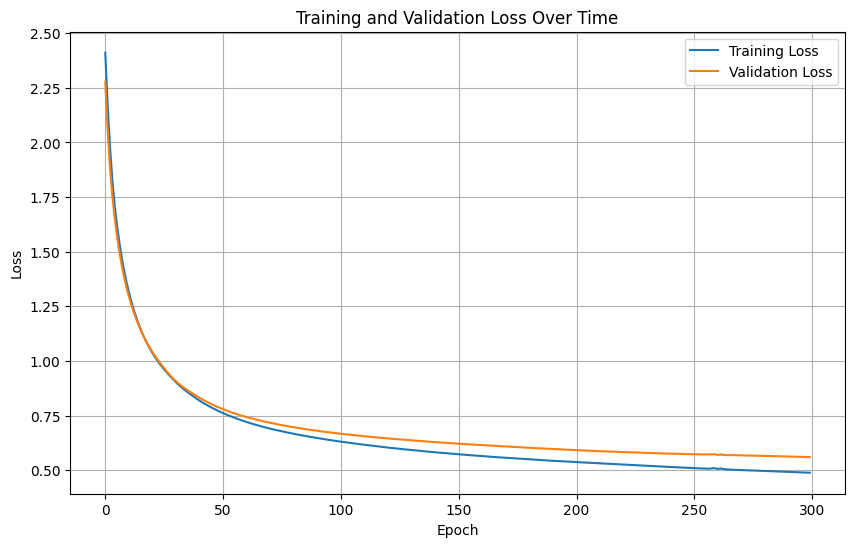

In [25]:
plt.figure(figsize=(10, 6))

# Plot training and validation loss values
plt.plot(history.history['loss'], label='Training Loss')

if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Section 6: Performance of the model

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Generate predictions on the test data
predictions = model.predict(scaled_test_df.drop(columns=['Export_Value_3_Years_Ahead_Category']))
predicted_classes = np.argmax(predictions, axis=1)

true_labels = scaled_test_df['Export_Value_3_Years_Ahead_Category'].values

# Calculate accuracy
accuracy = round(accuracy_score(true_labels, predicted_classes), 2)
class_report = classification_report(true_labels, predicted_classes)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', class_report)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.86      0.87       899
         1.0       0.79      0.82      0.81       894
         2.0       0.93      0.93      0.93       877

    accuracy                           0.87      2670
   macro avg       0.87      0.87      0.87      2670
weighted avg       0.87      0.87      0.87      2670



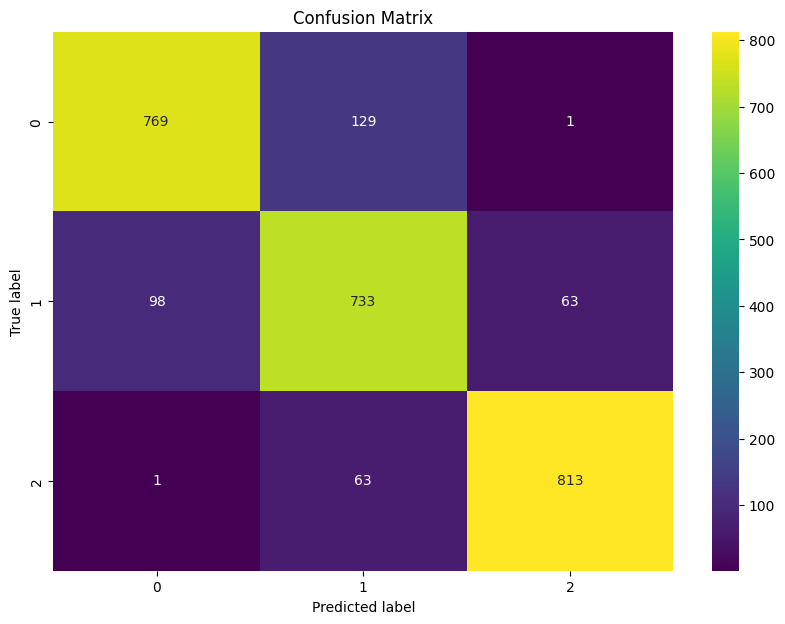

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Save the results to a CSV file
results_df = pd.DataFrame({
    'Id': range(1, len(predicted_classes) + 1),
    'True_Label': true_labels,
    'Predicted_Class': predicted_classes,
})

results_df.to_csv('classification_results.csv', index=False)